In [2]:
!nvidia-smi

Thu Sep 11 15:14:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050        Off |   00000000:03:00.0 Off |                  N/A |
| 38%   28C    P8             N/A /   75W |       8MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Сюда нужно будет написать настройку окружения

In [9]:
!sudo apt install python3.10-dev
!cd ManiSkill && uv pip install -e . && cd ..
!cd SimplerEnv && uv pip install -e . && cd ..

[sudo] password for jezv: 
sudo: a password is required
^C
Using Python 3.10.12 environment at: /home/jezv/Projects/RL4VLA/.venv
Resolved 97 packages in 348ms                                        
   Building mani-skill @ file:///home/jezv/Projects/RL4VLA/ManiSkill   
      Built mani-skill @ file:///home/jezv/Projects/RL4VLA/ManiSkill
Prepared 1 package in 190ms                                              
Uninstalled 1 package in 0.34ms
Installed 1 package in 0.71msfrom file:///home/jezv/Projects
 ~ mani-skill==3.0.0b20 (from file:///home/jezv/Projects/RL4VLA/ManiSkill)
Using Python 3.10.12 environment at: /home/jezv/Projects/RL4VLA/.venv
Resolved 1 package in 303ms                                          
   Building simpler-env @ file:///home/jezv/Projects/RL4VLA/SimplerEnv 
      Built simpler-env @ file:///home/jezv/Projects/RL4VLA/SimplerEnv
Prepared 1 package in 127ms                                              
Uninstalled 1 package in 0.37ms
Installed 1 package in 0.80ms

In [29]:
!uv add matplotlib

Resolved 48 packages in 1.10s                                        
⠹ Preparing packages... (0/1)                                                   
⠹ Preparing packages... (0/1)--------------     0 B/16.02 MiB           
⠹ Preparing packages... (0/1)-------------- 16.00 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 32.00 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 41.17 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 43.90 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 49.39 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 54.87 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 60.35 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 61.06 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 77.06 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 81.64 KiB/16.02 MiB         
⠹ Preparing packages... (0/1)-------------- 97

In [10]:
import site
site.main()

In [22]:
!export CUDA_VISIBLE_DEVICES=1

In [21]:
from mani_skill.utils.registration import REGISTERED_ENVS

print(REGISTERED_ENVS.keys())

dict_keys(['SceneManipulation-v1', 'ArchitecTHOR_SceneManipulation-v1', 'ReplicaCAD_SceneManipulation-v1', 'ReplicaCADTidyHouseTrain_SceneManipulation-v1', 'ReplicaCADTidyHouseVal_SceneManipulation-v1', 'ReplicaCADPrepareGroceriesTrain_SceneManipulation-v1', 'ReplicaCADPrepareGroceriesVal_SceneManipulation-v1', 'ReplicaCADSetTableTrain_SceneManipulation-v1', 'ReplicaCADSetTableVal_SceneManipulation-v1', 'MS-CartpoleBalance-v1', 'MS-CartpoleSwingUp-v1', 'MS-HopperStand-v1', 'MS-HopperHop-v1', 'MS-HumanoidStand-v1', 'MS-HumanoidWalk-v1', 'MS-HumanoidRun-v1', 'MS-AntWalk-v1', 'MS-AntRun-v1', 'RotateValveLevel0-v1', 'RotateValveLevel1-v1', 'RotateValveLevel2-v1', 'RotateValveLevel3-v1', 'RotateValveLevel4-v1', 'RotateSingleObjectInHandLevel0-v1', 'RotateSingleObjectInHandLevel1-v1', 'RotateSingleObjectInHandLevel2-v1', 'RotateSingleObjectInHandLevel3-v1', 'PutCarrotOnPlateInScene-v1', 'PutEggplantInBasketScene-v1', 'StackGreenCubeOnYellowCubeBakedTexInScene-v1', 'PutSpoonOnTableClothInScen

xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)
Observation {'agent': {'qpos': tensor([[-0.0184,  0.0399,  0.2224, -0.0046,  1.3652,  0.0015,  0.0370,  0.0370]]), 'qvel': tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]), 'controller': {'arm': {'target_pose': tensor([[ 0.2921, -0.0061,  0.1353,  0.6867,  0.0053,  0.7269, -0.0081]])}}}, 'extra': {}, 'sensor_param': {'3rd_view_camera': {'extrinsic_cv': tensor([[[-4.8393e-01,  8.7511e-01,  1.4901e-08, -9.3382e-02],
         [ 6.0256e-01,  3.3321e-01, -7.2518e-01,  7.4076e-01],
         [-6.3461e-01, -3.5094e-01, -6.8855e-01,  1.0062e+00]]]), 'cam2world_gl': tensor([[[-4.8393e-01, -6.0256e-01,  6.3461e-01,  1.4700e-01],
         [ 8.7511e-01, -3.3321e-01,  3.5094e-01,  1.8800e-01],
         [-2.9802e-08,  7.2518e-01,  6.8855e-01,  1.2300e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]]), 'intrinsic_cv': tensor([[[623.5880,   0.0000, 319.5010],
         [  0.0000, 623.5880, 239.5450],
         [  0.0000,   0.0000,   1.0000]]

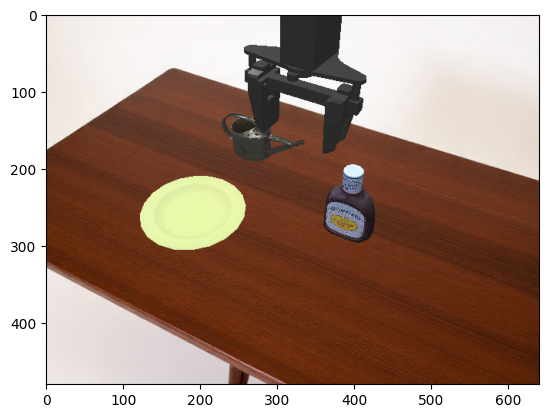

In [ ]:
import gymnasium as gym
import mani_skill.envs
import matplotlib.pyplot as plt


env = gym.make('PutOnPlateInScene25MultiCarrot-v1', 
               num_envs=1,
               obs_mode='rgb+segmentation')

# env.get_sensor_images()

# sapien.render_config.rt_use_denoiser = False

obs, reset_info = env.reset()
instruction = env.unwrapped.get_language_instruction()
print('Observation', obs)
print("Reset info", reset_info)
print("Instruction", instruction)
print(env.unwrapped.extra_actor)
plt.imshow(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])